In [1]:
## Standard Library
import os
import re
import csv
import sys
import time

from functools import wraps

## Time counter
clock = time.perf_counter

In [2]:
## Third-party
from graph_tool.all import Graph, graph_draw
from graph_tool.stats import distance_histogram
from graph_tool.centrality import betweenness
from graph_tool.topology import label_components, shortest_distance

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')

def gmin(x, w):
    return np.min(x)

def gmax(x, w):
    return np.max(x)

def gmean(x, w):
    return np.average(x, weights=w)

def gstddev(x, w):
    return np.sqrt(np.average(np.power(x-np.average(x, weights=w), 2), weights=w))

def gmedian(x, w):
    z = np.cumsum(w)
    return x[np.searchsorted(z, z[-1] / 2)]

In [3]:
## LaTeX interface
class LaTeX:
    
    RE_TABLE = {
        r'±' : r'\pm',
        r'{' : r'\{',
        r'}' : r'\}'
    } 
    RE_PATTERN = '|'.join(re.escape(k) for k in RE_TABLE)
    RE_REGEX = re.compile(RE_PATTERN, flags=re.MULTILINE)
    
    @classmethod
    def tex(cls, s: str):
        return cls.RE_REGEX.sub(lambda m: cls.RE_TABLE.get(m.group(0)), s)
    
    @classmethod
    def table(cls, a: np.array):
        m, n = a.shape
        ...
        
    @classmethod
    def number(cls, x: float):
        s = str(float(x))
        k = len(s) - 1
        while s[k] != '.':
            if s[k] == '0':
                k -= 1
            else:
                return s[:k+1]
        else:
            return s[:k]

In [4]:
def timer(title=None):
    def wrapper(callback):
        def timed_callback(*args, **kwargs):
            t = clock()
            x = callback(*args, **kwargs)
            t = clock() - t
            print(f"{title + ' ' if title is not None else ''}:: {t:.2f}s")
            return x
        return timed_callback
    return wrapper


## Analysis
class Analysis:
    
    MAX_INT = np.iinfo('int32').max
    MIN_INT = np.iinfo('int32').min
    
    def __init__(self, gname: str):
        self.gname = gname
        self.g = self.load_graph(self.gname)
        self.e = self.g.get_edges()
        self.v = self.g.get_vertices()
        self.m = len(self.e)
        self.n = len(self.v)
        
        self.x = np.arange(self.n + 1, dtype=int)
        
        self.dm = self.g.new_vp("double", np.inf)
        
    ## Loading Interface
    @classmethod
    @timer('Grafo Carregado')
    def load_graph(cls, fname: str) -> Graph:
        fdir = os.path.join(f'..', f'data') 
        fpath = os.path.join(fdir, fname)
        if os.path.exists(fpath):
            g = Graph()
            g.load(file_name=fpath, fmt='gt')
            return g
        else:
            raise FileNotFoundError('Invalid Graph, options are:\n' + '\n'.join(os.listdir(fdir)))
        
    @property
    def density(self):
        if self.g.is_directed():
            return self.m / (self.n * (self.n - 1))
        else:
            return self.m / self.nn
        
    @property
    def nn(self):
        "n choose 2"
        return ((self.n - 1) * self.n) // 2
        
    @property
    def avg_degree(self):
        if self.g.is_directed():
            return self.m / self.n
        else:
            return (2 * self.m) / self.n
        
    @property
    def ncomponents(self):
        return len(self.com)
        
    ## Metric Functions definition
    @timer('Grau')
    def degrees(self):
        deg_k = np.zeros(self.n + 1)
        deg = self.g.get_total_degrees(self.v)
        np.add.at(deg_k, deg, 1)
        
        k = (deg_k > 0)
        x = self.x[k]
        y = (deg_k[k] / float(self.n))
        
        return {
            'x' : x,
            'y' : y, ## empirical distribution
            'min' : np.min(deg), ## minimum degree found
            'max' : np.max(deg), ## maximum degree found
            'avg' : np.mean(deg),
            'med' : np.median(deg),
            'std' : np.std(deg),
            'title' : 'Grau dos vértices'
        }
            
    @timer('Distâncias')
    def distances(self):
        dis_k = np.zeros(self.n + 1, dtype=int)
        dis_min = self.MAX_INT
        dis_max = self.MIN_INT
        i = 1
        for v in self.v:
            dis_a = shortest_distance(self.g, source=v, directed=self.g.is_directed()).a
            dis = dis_a[(0 <= dis_a) & (dis_a < self.MAX_INT)]
            dis_min = min(dis_min, np.min(dis, initial=self.MAX_INT))
            dis_max = max(dis_max, np.max(dis, initial=self.MIN_INT))
            np.add.at(dis_k, dis, 1)
            print(f'ds[{i}/{self.n}]', end='\r'); i += 1;
        else:
            print('                          ', end='\r')
            k = (dis_k > 0)
            x = self.x[k]
            w = dis_k[k]
            y = (w / float(self.nn))
                
        return {
            'x' : x,
            'y' : y, ## empirical distribution
            'min' : dis_min, ## minimum distance found
            'max' : dis_max, ## maximum distance found
            'avg' : gmean(x, w),
            'med' : gmedian(x, w),
            'std' : gstddev(x, w),
            'title' : 'Distâncias'
        }

    @timer('Componentes conexas')
    def components(self, ax=None):
        com = np.zeros(self.n, dtype=int)
        np.add.at(com, label_components(self.g, directed=self.g.is_directed())[0].a, 1)
        com = com[com > 0]
        n = com.shape[0]
        com_k = np.zeros(self.n + 1, dtype=int)
        np.add.at(com_k, com, 1)
        k = (com_k > 0)
        x = self.x[k]
        y = (com_k[k] / n)
        
        return {
            'n' : n,
            'x' : x,
            'y' : y, ## empirical distribution
            'min' : np.min(com),
            'max' : np.max(com), 
            'avg' : np.mean(com),
            'med' : np.median(com),
            'std' : np.std(com),
            'title' : 'Tamanho das Componentes.'
        }
        
    @timer('Centralidade')
    def betweenness(self):
        btw = betweenness(self.g)[0].a ## vertex betweenness
        
        v, u = np.histogram(btw)
        
        x = (u[:-1] + u[1:]) / 2
        y = v / np.sum(v)
        
        return {
            'x' : x,
            'y' : y, ## empirical distribution
            'min' : np.min(btw),
            'max' : np.max(btw),
            'avg' : np.mean(btw),
            'med' : np.median(btw),
            'std' : np.std(btw),
            'title' : 'Centralidade (Betweenness).'
        }
        
        
    
    
    def fplot(self, ax, logx=False, **kwargs):
        
        title = f"{kwargs['title']} {kwargs['avg']:.1f} ({kwargs['med']:.1f}) ± {kwargs['std']:.1f} ∈ [{kwargs['min']:.1f}, {kwargs['max']:.1f}]"
        
        ax.set_title(title)
        
        x = kwargs['x']
        y = kwargs['y']

        if logx:
            ax.stem(x, y, use_line_collection=True)
            ax.set_xscale('log')
        else:
            ax.stem(x, y, use_line_collection=True)

    def analysis(self):
        
        PATH = os.path.join('..', 'results')
        
        self.texfile = open(os.path.join(PATH, f'{self.gname}.txt'), 'w', encoding='utf8')

        graph_draw(self.g, output=os.path.join(PATH, f"{self.gname}-graph.png"), fmt="png")
        
        ## Plot
        fig, ax = plt.subplots(2, 2)
        
        self.deg = self.degrees()
        self.dis = self.distances()
        self.com = self.components()
        self.btw = self.betweenness()
        
        fig.suptitle(f"Grafo: {self.gname.upper()} - Componentes Conexas: {self.com['n']} - |V| = {self.n} |E| = {self.m}")
    
        self.fplot(ax[0,0], **self.deg, logx=True)
        self.fplot(ax[0,1], **self.dis)
        self.fplot(ax[1,0], **self.com, logx=True)
        self.fplot(ax[1,1], **self.btw)
       
        plt.savefig(os.path.join(PATH, f"{self.gname}-data.pdf"))
        
        self.texfile.close()

In [5]:
def main():
    TARGETS = [
        'protein',
        'metabolic',
        'powergrid',
        'collaboration',
        'email',
    ]

    for gname in TARGETS:
        Analysis(gname).analysis()

Grafo Carregado :: 0.00s
Grau :: 0.00s
Distâncias :: 2.48s       
Componentes conexas :: 0.00s
Centralidade :: 0.13s
Grafo Carregado :: 0.00s
Grau :: 0.00s
Distâncias :: 0.93s       
Componentes conexas :: 0.00s
Centralidade :: 0.04s
Grafo Carregado :: 0.00s
Grau :: 0.00s
Distâncias :: 9.51s       
Componentes conexas :: 0.00s
Centralidade :: 1.02s
Grafo Carregado :: 0.02s
Grau :: 0.00s
Distâncias :: 185.28s     
Componentes conexas :: 0.01s
Centralidade :: 101.91s
Grafo Carregado :: 0.02s
Grau :: 0.01s
Distâncias :: 204.55s     
Componentes conexas :: 0.02s
Centralidade :: 79.01s


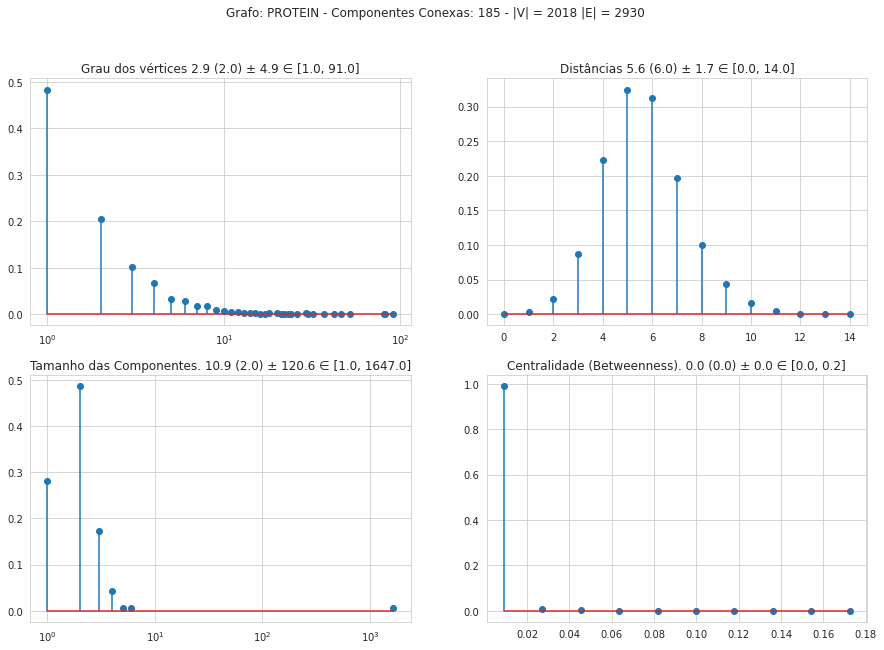

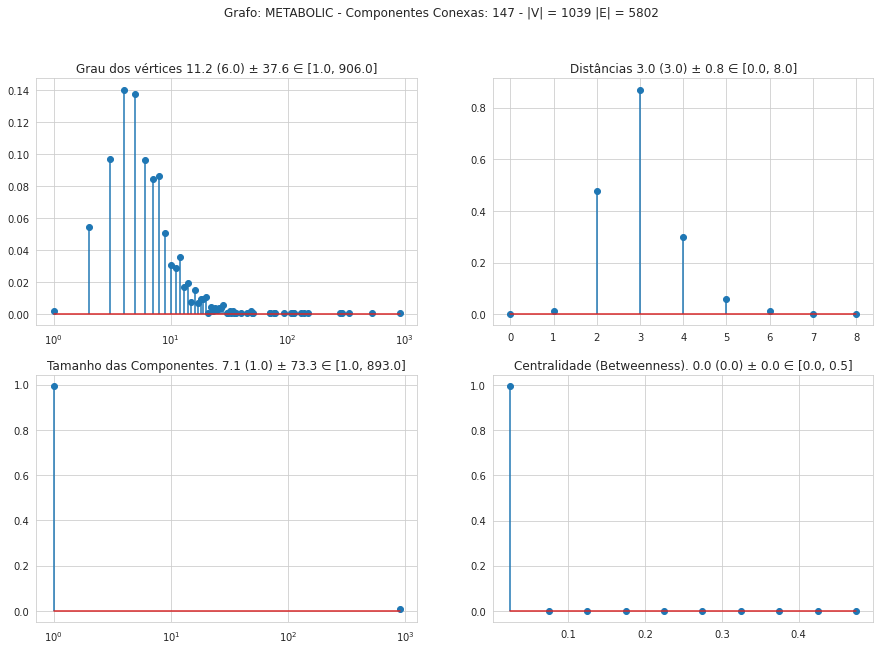

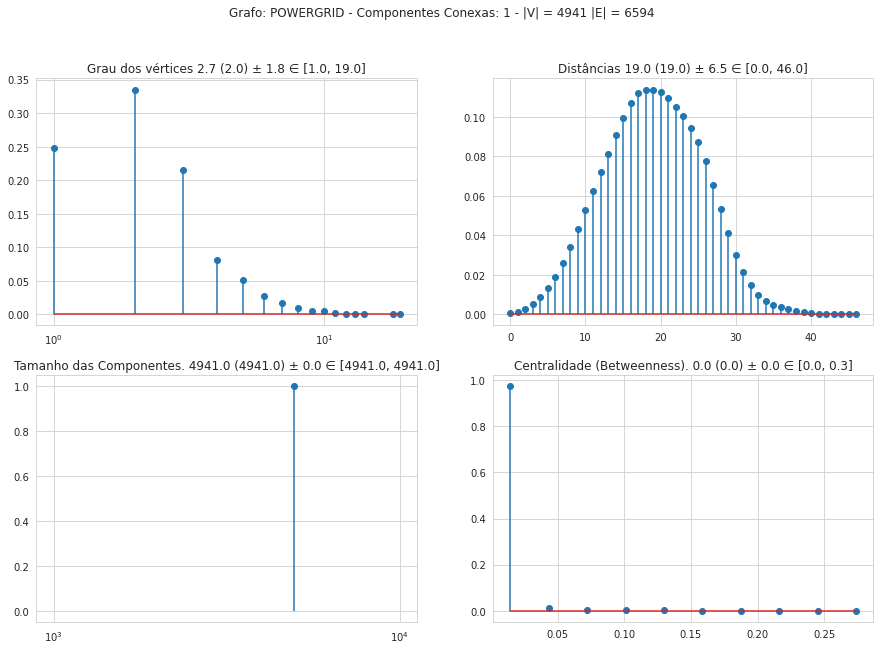

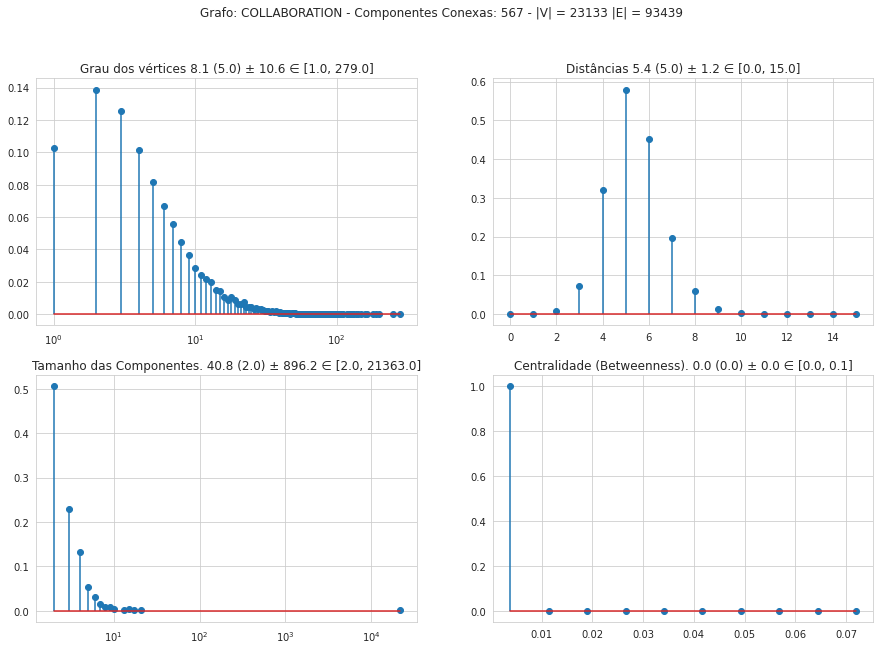

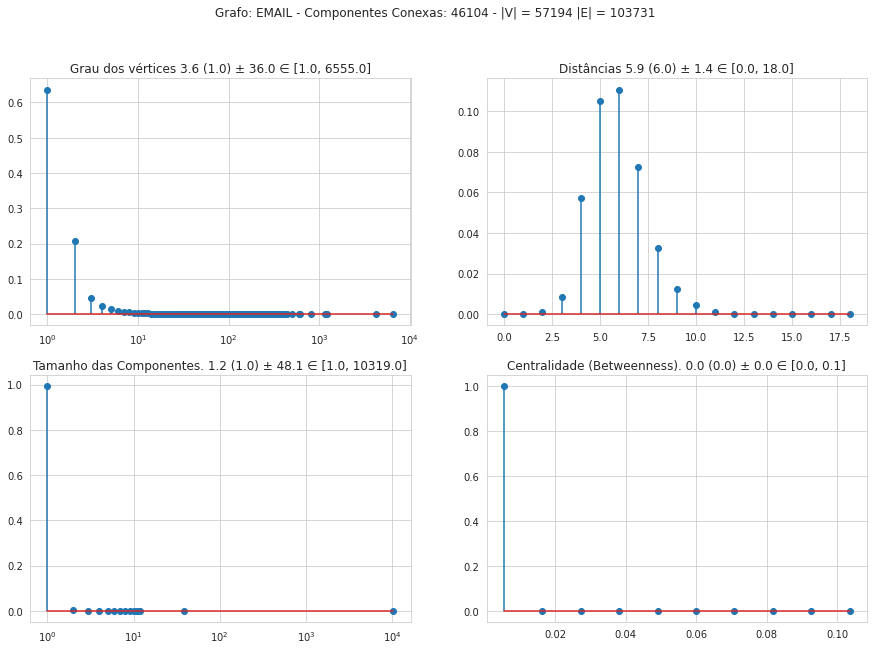

In [6]:
main()